<a href="https://colab.research.google.com/github/poojashreeNS/CMPE_297_FinalProject/blob/main/New_version_Image_Caption_Transfer_Learning_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Image Caption Generation using Transformers**

The task of captioning an image can be thought of as an end-to-end sequence-to-sequence embedding task, where the input sequences are the image pixels and the output is a caption that describes the image.

Due to the mutual exclusivity of picture and text sequences, this task requires the use of two interconnected models, one of which is dedicated to image encoding and the other to text decoding.

**Imports**

In [1]:
!pip install transformers
!pip install pandas
!pip install joblib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 5.2 MB/s 
     |████████████████████████████████| 182 kB 60.4 MB/s 
     |████████████████████████████████| 7.6 MB 49.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import json
import pandas as pd
import torch
from tokenizers import ByteLevelBPETokenizer
from transformers import RobertaConfig, RobertaModel, RobertaForMaskedLM, DataCollatorForLanguageModeling, RobertaTokenizerFast, TrainingArguments, Trainer
from pathlib import Path
from tokenizers import ByteLevelBPETokenizer

In [3]:
import numpy as np
from collections import OrderedDict,Counter
from tensorflow.keras.utils import load_img
import matplotlib.pyplot as plt

## **Decoder**

As task one we are preparing our decoder by fine-tuning teh self-attentation weights of our language transformer model on our dataset. This will help decoder to learn new words and generate captions.



**Setting Model Parameters**

Defining hyper parameters like learning rate, batch size, maximum length of text sequence to be generated by the decoder.

In [4]:
TRAIN_BATCH_SIZE = 20   # input batch size for training (default: 64)
VALID_BATCH_SIZE = 5   # input batch size for testing (default: 1000)
VAL_EPOCHS = 1 
LEARNING_RATE = 1e-4    # learning rate (default: 0.01)
SEED = 42               # random seed (default: 42)
MAX_LEN = 128           # Max length for Input description

TRAIN_EPOCHS = 25       # number of epochs to train (default: 5)
WEIGHT_DECAY = 0.01
SEED = 42               # random seed (default: 42)
SUMMARY_LEN = 20   # Maximum length of caption generated  

**Set GPU for training if avaliable**

In [5]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


**Flickr 8K Dataset**

A new benchmark collection of 8,000 pictures with five possible captions for each one, clearly describing the prominent people, places, and things in the image, serves as the industry standard for sentence-based image description and search.

**Why?**
* It is small in size. So, the model can be trained easily on low-end laptops/desktops.
* Data is properly labelled. For each image 5 captions are provided.
* The dataset is available for free.



**Preprocessing**


1. Loading the json file containing the file name of the image and any associated captions.
2. Prepending image path to the image file names.
3. Preprocessing captions before tokenization.
4. Train a own tokenizer and save it.


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
!ls /content/drive/MyDrive/Cmp297/PoojashreeNS/Dataset

Byte_tokenizer	desktop.ini			   RobertaMLM
captions.txt	Image_Cationing_VIT_Roberta_iter2  text_split
data.json	Images				   VIT_Captioning


Loading the json file with Image file name and captions associated to the image.

Preprocessing the captions with start and end token

In [18]:
# os.chdir(r'F://Pooja-DND//Adv Deep Learning Assignments//Project_dataset//Dataset') 
os.chdir(r'/content/drive/MyDrive/Cmp297/PoojashreeNS/Dataset') 

# CONVERTING TO DICTIONARY
with open('data.json', 'r') as openfile:

    json_object = json.load(openfile)

images_caption_dict = dict(json_object)

# images_path = 'F://Pooja-DND//Adv Deep Learning Assignments//Project_dataset//Dataset//Images//'
images_path = '/content/drive/MyDrive/Cmp297/PoojashreeNS/Dataset/Images/'
images = list(images_caption_dict.keys())
# PREPENDING IMAGE PATHS TO THE IMAGE FILE NAMES
for image_path in images:
    if image_path.endswith('jpg'):
        new = images_path + image_path.split('/')[-1]
        images_caption_dict[new] = images_caption_dict.pop(image_path)
    else:
        images_caption_dict.pop(image_path)

**Create a dataframe with images path and captions**

In [19]:
# PREPROCESSING CAPTIONS BEFORE TOKENIZING
df = pd.DataFrame([])

captions = []
images = []
for image in list(images_caption_dict.keys()):
    caption = images_caption_dict[image]
    for capt in caption:
        captions.append(capt.replace('<s> ','').replace('  <e>','').strip())
        images.append(image)
        
df['images'] = images
df['captions'] = captions

**EDA and Visualization**



Displaying Dataset

In [20]:
df

,images,captions
0,/content/drive/MyDrive/Cmp297/PoojashreeNS/Dat...,a child in a pink dress is climbing up a set o...
1,/content/drive/MyDrive/Cmp297/PoojashreeNS/Dat...,a girl going into a wooden building
2,/content/drive/MyDrive/Cmp297/PoojashreeNS/Dat...,a little girl climbing into a wooden playhouse
3,/content/drive/MyDrive/Cmp297/PoojashreeNS/Dat...,a little girl climbing the stairs to her playh...
4,/content/drive/MyDrive/Cmp297/PoojashreeNS/Dat...,a little girl in a pink dress going into a woo...
...,...,...
40450,/content/drive/MyDrive/Cmp297/PoojashreeNS/Dat...,a man in a pink shirt limbs a rock face <e>
40451,/content/drive/MyDrive/Cmp297/PoojashreeNS/Dat...,a man is rock climbing high in the air
40452,/content/drive/MyDrive/Cmp297/PoojashreeNS/Dat...,a person in a red shirt climbing up a rock fac...
40453,/content/drive/MyDrive/Cmp297/PoojashreeNS/Dat...,a rock climber in a red shirt


Understanding the size of dataset by eliminating duplicates and number of captions per image

In [ ]:
uni_filenames = np.unique(df.images.values)
print("The number of unique file names : {}".format(len(uni_filenames)))
print("The distribution of the number of captions for each image:",Counter(Counter(df.images.values).values()))

The number of unique file names : 8091
The distribution of the number of captions for each image: Counter({5: 8091})


Getting the frequency of words

In [ ]:
# Most Frequent Words
def df_word(df_txt):
    vocabulary = []
    for txt in df_txt.captions.values:
        vocabulary.extend(txt.split())
    print('Vocabulary Size: %d' % len(set(vocabulary)))
    ct = Counter(vocabulary)
    dfword = pd.DataFrame({"word":ct.keys(),"count":ct.values()})
    dfword = dfword.reset_index()[["word","count"]]
    return(dfword)
dfword = df_word(df)
dfword.head(5)

Vocabulary Size: 6930


,word,count
0,a,62988
1,child,1549
2,in,18993
3,pink,739
4,dress,348


Analysing most occured and less occured words

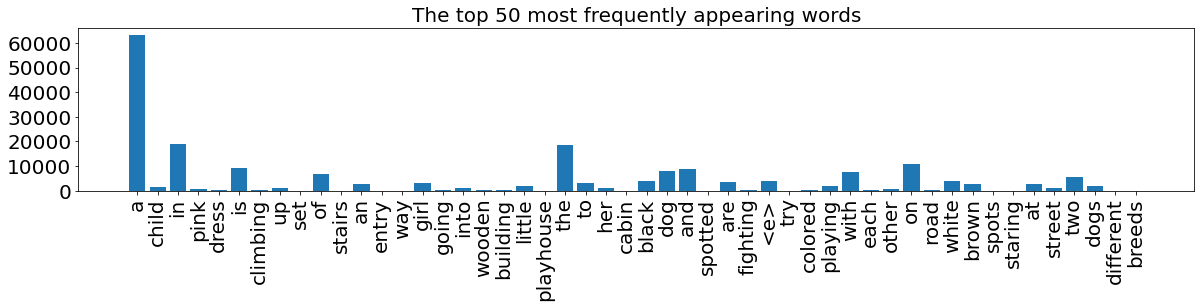

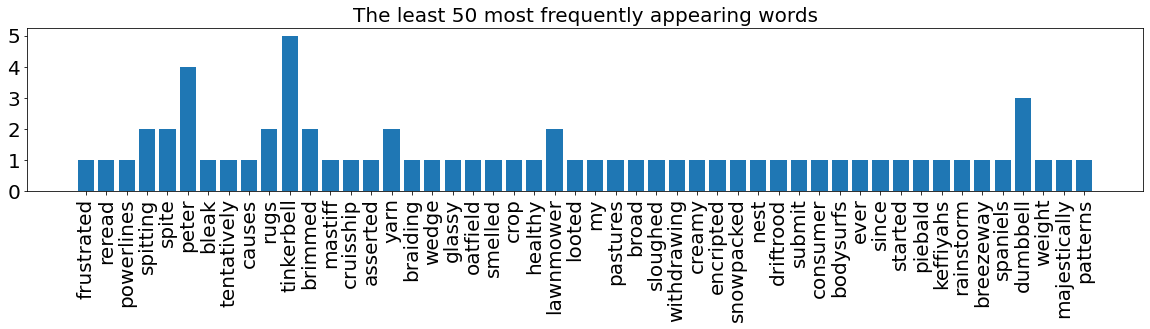

In [ ]:
# Most Occuring & Least Occuring Words
topn = 50

def plthist(dfsub, title="The top 50 most frequently appearing words"):
    plt.figure(figsize=(20,3))
    plt.bar(dfsub.index,dfsub["count"])
    plt.yticks(fontsize=20)
    plt.xticks(dfsub.index,dfsub["word"],rotation=90,fontsize=20)
    plt.title(title,fontsize=20)
    plt.show()

plthist(dfword.iloc[:topn,:],
        title="The top 50 most frequently appearing words")
plthist(dfword.iloc[-topn:,:],
        title="The least 50 most frequently appearing words")

**Training Decoder: Roberta model for masked language Modeling**

It is always better to train a tokenizer on the corpus of text so that it doesn't miss out on words important for the specific task. If the word in the corpus is not present in the tokenizer vocabulary it may be assigned an unknown “<UNK>” token which will be loss of information.

The captions are needed to be converted into text files, for the tokenizer to learn on the corpus of captions we have.

In [ ]:
# Store values in a dataframe column (Series object) to files, one file per record
os.mkdir("./text_split")
def column_to_files(column, prefix, txt_files_dir = "./text_split"):
    # The prefix is a unique ID to avoid to overwrite a text file
    i=prefix
    #For every value in the df, with just one column
    for row in column.to_list():
      # Create the filename using the prefix ID
        file_name = os.path.join(txt_files_dir, str(i)+'.txt')
        try:
            # Create the file and write the column text to it
            f = open(file_name, 'wb')
            f.write(row.encode('utf-8'))
            f.close()
        except Exception as e:  #catch exceptions(for eg. empty rows)
            print(row, e) 
        i+=1
    # Return the last ID
    return i

data = df["captions"]
# Removing the end of line character \n
data = data.replace("\n"," ")
# Set the ID to 0
prefix=0
# Create a file for every description value
prefix = column_to_files(data, prefix)

we are training a Byte Level BPE Tokenizer which starts constructing tokens at byte level rather than word level.

In [ ]:
%%time 
paths = [str(x) for x in Path(".").glob("text_split/*.txt")]

# Initialize a tokenizer
tokenizer = ByteLevelBPETokenizer(lowercase=True)

# Customize training
tokenizer.train(files=paths, vocab_size=10000, min_frequency=2,
                show_progress=True,
                special_tokens=[
                                "<s>",
                                "<pad>",
                                "<e>",
                                "<unk>",
                                "<mask>"])

CPU times: total: 56.5 s
Wall time: 1min 22s


After training we save the tokenizer and then call it using the decoder model's tokenizer wrapper function which will wrap our trained tokenizer.

In [ ]:
os.mkdir('Byte_tokenizer')
tokenizer.save_model('Byte_tokenizer')

['Byte_tokenizer\\vocab.json', 'Byte_tokenizer\\merges.txt']

We have used Roberta as a Text decoder model. 

We are training decoder on the captions to fine tune it on the language structure and create better and brief description of Images.

For training the Language model we used masked LM method to initialize. In this method a random word in the sentence is masked while training, and the model tries to predict the word which will possibly be the right choice. The model keeps on learning till it starts predicting right words.

In [ ]:
config = RobertaConfig(
    vocab_size=10000,
    max_position_embeddings=514,
    num_attention_heads=12,
    num_hidden_layers=6,
    type_vocab_size=1,
)

model = RobertaForMaskedLM(config=config)
model.to(device)
print('Num parameters: ',model.num_parameters())

# Create the tokenizer from a trained one
tokenizer = RobertaTokenizerFast.from_pretrained('Byte_tokenizer', max_len=MAX_LEN)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Num parameters:  51206416


In [ ]:
from torch.utils.data.dataset import Dataset

Before training the model, we need to process the data by creating a data loader.

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, df, tokenizer):
        # or use the RobertaTokenizer from `transformers` directly.

        self.examples = []
        
        for example in df.values:
            x=tokenizer.encode_plus(example, max_length = MAX_LEN, truncation=True, padding=True)
            self.examples += [x.input_ids]

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, i):
        # We’ll pad at the batch level.
        return torch.tensor(self.examples[i])
    
    
# Create the train and evaluation dataset 
train_dataset = CustomDataset(df['captions'][:38000], tokenizer) 
eval_dataset = CustomDataset(df['captions'][38000:], tokenizer)

Also, we use a handy tool, Data collator for Language Modelling which will randomly mask words while training.

In [ ]:
from transformers import DataCollatorForLanguageModeling

# Define the Data Collator
collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.1
)

Now using the previously defined hyper parameters we are allocating the training arguments for training and start training the model.

In [ ]:
model_folder = "RobertaMLM"
# Define the training arguments
training_args = TrainingArguments(
    output_dir=model_folder,
    fp16=True,
    overwrite_output_dir=True,
    evaluation_strategy = 'epoch',
    num_train_epochs=TRAIN_EPOCHS,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    per_device_train_batch_size=TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=VALID_BATCH_SIZE,
    save_steps=8192,
    #eval_steps=4096,
    save_total_limit=1,
)

In [ ]:
# Create the trainer for our model
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collator,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    #prediction_loss_only=True,
)
# Train the model
trainer.train()

Using cuda_amp half precision backend
F:\Pooja-DND\Anaconda\envs\gpu_pytorch\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38000
  Num Epochs = 30
  Instantaneous batch size per device = 20
  Total train batch size (w. parallel, distributed & accumulation) = 20
  Gradient Accumulation steps = 1
  Total optimization steps = 57000
  Number of trainable parameters = 51206416


Epoch,Training Loss,Validation Loss
1,4.627500,4.002158
2,3.810300,3.582951
3,3.466200,3.447007
4,3.240100,3.273286
5,3.122700,3.104625
6,3.009400,2.948525
7,2.813200,2.919137
8,2.754900,2.748957
9,2.694100,2.812254
10,2.578200,2.742763


***** Running Evaluation *****
  Num examples = 2455
  Batch size = 5
***** Running Evaluation *****
  Num examples = 2455
  Batch size = 5
***** Running Evaluation *****
  Num examples = 2455
  Batch size = 5
***** Running Evaluation *****
  Num examples = 2455
  Batch size = 5
Saving model checkpoint to RobertaMLM\checkpoint-8192
Configuration saved in RobertaMLM\checkpoint-8192\config.json
Model weights saved in RobertaMLM\checkpoint-8192\pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2455
  Batch size = 5
***** Running Evaluation *****
  Num examples = 2455
  Batch size = 5
***** Running Evaluation *****
  Num examples = 2455
  Batch size = 5
***** Running Evaluation *****
  Num examples = 2455
  Batch size = 5
Saving model checkpoint to RobertaMLM\checkpoint-16384
Configuration saved in RobertaMLM\checkpoint-16384\config.json
Model weights saved in RobertaMLM\checkpoint-16384\pytorch_model.bin
Deleting older checkpoint [RobertaMLM\checkpoint-8192] due to args.sa

TrainOutput(global_step=57000, training_loss=2.505483723958333, metrics={'train_runtime': 1929.4016, 'train_samples_per_second': 590.857, 'train_steps_per_second': 29.543, 'total_flos': 6430552632516480.0, 'train_loss': 2.505483723958333, 'epoch': 30.0})

In order to evaluate the language model, we are using perplexity as metrics.

In [ ]:
import math
eval_results = trainer.evaluate()

print(f"Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

***** Running Evaluation *****
  Num examples = 2455
  Batch size = 5


Perplexity: 8.68


Finally save the decoder and tokenizer for further use in the second step.

In [ ]:
tokenizer.save_pretrained('Byte_tokenizer')
trainer.save_model(model_folder)

tokenizer config file saved in Byte_tokenizer\tokenizer_config.json
Special tokens file saved in Byte_tokenizer\special_tokens_map.json
Saving model checkpoint to RobertaMLM
Configuration saved in RobertaMLM\config.json
Model weights saved in RobertaMLM\pytorch_model.bin


In [ ]:
from transformers import pipeline

fill = pipeline(
    "fill-mask",
    model= r'RobertaMLM',
    tokenizer= 'Byte_tokenizer'
)
fill("a girl going into a <mask> building")

loading configuration file RobertaMLM\config.json
Model config RobertaConfig {
  "_name_or_path": "RobertaMLM",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.24.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 10000
}

loading configuration file RobertaMLM\config.json
Model config RobertaConfig {
  "_name_or_path": "RobertaMLM",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,


[{'score': 0.09233200550079346,
  'token': 340,
  'token_str': ' white',
  'sequence': 'a girl going into a white building'},
 {'score': 0.0889720618724823,
  'token': 1043,
  'token_str': ' brick',
  'sequence': 'a girl going into a brick building'},
 {'score': 0.0883152186870575,
  'token': 491,
  'token_str': ' large',
  'sequence': 'a girl going into a large building'},
 {'score': 0.06560676544904709,
  'token': 849,
  'token_str': ' wooden',
  'sequence': 'a girl going into a wooden building'},
 {'score': 0.0488705150783062,
  'token': 402,
  'token_str': ' blue',
  'sequence': 'a girl going into a blue building'}]

## **Encoder**

In the second task we will start with pre-processing data & initialize VED with pre trained Vision Transformer (from hugging face) & our fine-tuned Roberta model (from Decoder).

In [ ]:
!pip install datasets

In [ ]:
import datasets
import transformers
import pandas as pd
import numpy as np
import torch
from torch.utils.data.dataset import Dataset
from pathlib import Path

#Tokenizer from scratch on vocabulary of corpus
from tokenizers import ByteLevelBPETokenizer

# Decoder
from transformers import RobertaConfig
from transformers import RobertaForMaskedLM # RobertaLM for learning
from transformers import RobertaTokenizerFast # After training tokenizer we will wrap it so it can be used by Roberta model

#Encoder-Decoder Model
from transformers import VisionEncoderDecoderModel

#Training
# When using previous version of the library you need the following two lines
from transformers import Seq2SeqTrainer
from transformers import Seq2SeqTrainingArguments
# Latest version imports
from transformers import Trainer, TrainingArguments

**Train Test Split & Pre-processing**

In [ ]:
import random 
def train_test_split(dictionary):
    images = dictionary.keys()
    images_test = random.sample(images,int(0.3*len(images)))
    images_train = [img for img in images if img not in images_test]

    train_dict = {
      img: dictionary[img] for img in images_train
    }

    test_dict = {
      img: dictionary[img] for img in images_test
    }
    return(train_dict,test_dict)

train,test = train_test_split(images_caption_dict)

The dataset used in our project has 5 distinct captions associated to a single image. Due to compute constraints, we have created 5 distinct image caption pairs to have smaller input sequence, but we can use all 5 captions concatenated together by a separator token by just passing use_all = True in the function below

In [ ]:
import pandas as pd

def get_df(dictionary):
    df = pd.DataFrame([])

    captions = []
    images = []
    for image in list(images_caption_dict.keys()):
        caption = images_caption_dict[image]
        for capt in caption:
            captions.append(' '.join(capt.replace(' ',' ').replace('  ',' ').strip().split(' ')[:30]))
            images.append(image)

    df['images'] = images
    df['captions'] = captions
    return(df)

train_df = get_df(train)
test_df = get_df(test)

**Initialize Encoder Feature Extractor & Decoder Tokenizer**

Feature Extractor in Vision transformer is analogous to a tokenizer, because it slices the 3d image in to sequence of 3d cropped images as tokens and ready for input, just like a tokenizer.

In [ ]:
from transformers import ViTFeatureExtractor
from transformers import RobertaTokenizerFast
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
tokenizer = RobertaTokenizerFast.from_pretrained('Byte_tokenizer')

**Initialize Vision Encoder Decoder (VED)**

Initialize VED model and provide “Vision Transformer” as an encoder (from hugging face) and our pre-trained “Roberta” model as decoder 

In [ ]:
# set encoder decoder tying to True
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained\
                    ("google/vit-base-patch16-224-in21k", 'RobertaMLM', tie_encoder_decoder=True)
model.to(device)

Some weights of RobertaForCausalLM were not initialized from the model checkpoint at RobertaMLM and are newly initialized: ['roberta.encoder.layer.5.crossattention.self.query.weight', 'roberta.encoder.layer.0.crossattention.self.key.weight', 'roberta.encoder.layer.4.crossattention.self.key.bias', 'roberta.encoder.layer.1.crossattention.self.key.bias', 'roberta.encoder.layer.1.crossattention.output.LayerNorm.weight', 'roberta.encoder.layer.5.crossattention.self.key.weight', 'roberta.encoder.layer.3.crossattention.self.key.weight', 'roberta.encoder.layer.5.crossattention.self.value.bias', 'roberta.encoder.layer.5.crossattention.output.LayerNorm.bias', 'roberta.encoder.layer.3.crossattention.output.dense.bias', 'roberta.encoder.layer.3.crossattention.self.key.bias', 'roberta.encoder.layer.0.crossattention.self.value.weight', 'roberta.encoder.layer.0.crossattention.output.dense.bias', 'roberta.encoder.layer.1.crossattention.self.value.bias', 'roberta.encoder.layer.4.crossattention.self.que

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, 

Since tokenizer is initialized parallelly, the parameter settings below are necessary for the model to interpret input from the tokenizer.

In [ ]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = tokenizer.sep_token_id
model.config.max_length = 20
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

The VED model requires only 2 inputs

**pixel_values :** 3d image chunk sequence output from feature extractor.


**labels :** Token sequence output from tokenizer of desired captions.

**Create Dataset for training & evaluation**

In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image

batch_size=TRAIN_BATCH_SIZE  # change to 16 for full training

class IAMDataset(Dataset):
    def __init__(self, df, tokenizer,feature_extractor, decoder_max_length=31):
        self.df = df
        self.tokenizer = tokenizer
        self.feature_extractor = feature_extractor
        self.decoder_max_length = decoder_max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text 
        img_path = self.df['images'][idx]
        caption = self.df['captions'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(img_path).convert("RGB")
        pixel_values = self.feature_extractor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.tokenizer(caption, truncation = True,
                                          padding="max_length", 
                                          max_length=self.decoder_max_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding
    
train_dataset = IAMDataset(df=train_df.sample(frac=0.3,random_state=2).iloc[:10000].reset_index().drop('index',axis =1),
                           tokenizer=tokenizer,
                          feature_extractor= feature_extractor)
eval_dataset = IAMDataset(df=test_df.sample(frac=0.1,random_state=2)[:2000].reset_index().drop('index',axis =1),
                           tokenizer=tokenizer,feature_extractor= feature_extractor)

**Rouge Metrics to evaluate performance**

ROUGE (Recall-Oriented Understudy for Gisting Evaluation), it measures number of matching n-grams between the sequence generated by the model and desired sequence.

In [ ]:
# load rouge for validation
rouge = datasets.load_metric("rouge")

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    # all unnecessary tokens are removed
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    rouge_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge2"])["rouge2"].mid

    return {
        "rouge2_precision": round(rouge_output.precision, 4),
        "rouge2_recall": round(rouge_output.recall, 4),
        "rouge2_fmeasure": round(rouge_output.fmeasure, 4),
    }

C:\Users\bhara\AppData\Local\Temp\ipykernel_18548\1860282078.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge = datasets.load_metric("rouge")


In [ ]:
captioning_model = 'VIT_Captioning'

training_args = Seq2SeqTrainingArguments(
    output_dir=captioning_model,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    predict_with_generate=True,
    #evaluate_during_training=True,
    evaluation_strategy="epoch",
    do_train=True,
    do_eval=True,
    logging_steps=1024,  
    save_steps=2048, 
    warmup_steps=1024,  
    #max_steps=1500, # delete for full training
    num_train_epochs = TRAIN_EPOCHS, #TRAIN_EPOCHS
    overwrite_output_dir=True,
    save_total_limit=1,
)

from transformers import default_data_collator

# instantiate trainer
trainer = Seq2SeqTrainer(
    tokenizer=feature_extractor,
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)

Fine-tune the model, training and evaluating on the train dataset

In [ ]:
trainer.train()

F:\Pooja-DND\Anaconda\envs\gpu_pytorch\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 10000
  Num Epochs = 25
  Instantaneous batch size per device = 20
  Total train batch size (w. parallel, distributed & accumulation) = 20
  Gradient Accumulation steps = 1
  Total optimization steps = 12500
  Number of trainable parameters = 151779088


Epoch,Training Loss,Validation Loss,Rouge2 Precision,Rouge2 Recall,Rouge2 Fmeasure
1,No log,2.132886,0.084100,0.089300,0.084000
2,No log,1.887271,0.109500,0.115900,0.109600
3,2.944200,1.675660,0.135900,0.140100,0.133900
4,2.944200,1.488300,0.163700,0.173500,0.164000
5,1.805500,1.323099,0.195300,0.202300,0.194000
6,1.805500,1.164006,0.219900,0.228100,0.218800
7,1.465800,1.007328,0.260700,0.264600,0.257400
8,1.465800,0.881311,0.292000,0.297200,0.289500
9,1.169600,0.762402,0.347700,0.341000,0.339700
10,1.169600,0.659013,0.379000,0.387500,0.378300


***** Running Evaluation *****
  Num examples = 2000
  Batch size = 20
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 20
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 20
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 20
Saving model checkpoint to VIT_Captioning\checkpoint-2048
Configuration saved in VIT_Captioning\checkpoint-2048\config.json
Model weights saved in VIT_Captioning\checkpoint-2048\pytorch_model.bin
Feature extractor saved in VIT_Captioning\checkpoint-2048\preprocessor_config.json
Deleting older checkpoint [VIT_Captioning\checkpoint-14336] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 20
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 20
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 20
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 20
Saving model checkpoint to VIT_Captioning\checkpoint-4096
Config

TrainOutput(global_step=12500, training_loss=0.9107687213134765, metrics={'train_runtime': 8198.3897, 'train_samples_per_second': 30.494, 'train_steps_per_second': 1.525, 'total_flos': 3.2447116025856e+19, 'train_loss': 0.9107687213134765, 'epoch': 25.0})

Save the trained model for real time prediction

In [ ]:
trainer.save_model('Image_Cationing_VIT_Roberta_iter2')

Saving model checkpoint to Image_Cationing_VIT_Roberta_iter2
Configuration saved in Image_Cationing_VIT_Roberta_iter2\config.json
Model weights saved in Image_Cationing_VIT_Roberta_iter2\pytorch_model.bin
Feature extractor saved in Image_Cationing_VIT_Roberta_iter2\preprocessor_config.json


In [ ]:
t = VisionEncoderDecoderModel.from_pretrained('Image_Cationing_VIT_Roberta_iter2')

loading configuration file Image_Cationing_VIT_Roberta_iter2\config.json
Model config VisionEncoderDecoderConfig {
  "_commit_hash": null,
  "architectures": [
    "VisionEncoderDecoderModel"
  ],
  "decoder": {
    "_name_or_path": "RobertaMLM",
    "add_cross_attention": true,
    "architectures": [
      "RobertaForMaskedLM"
    ],
    "attention_probs_dropout_prob": 0.1,
    "bad_words_ids": null,
    "begin_suppress_tokens": null,
    "bos_token_id": 0,
    "chunk_size_feed_forward": 0,
    "classifier_dropout": null,
    "cross_attention_hidden_size": null,
    "decoder_start_token_id": null,
    "diversity_penalty": 0.0,
    "do_sample": false,
    "early_stopping": false,
    "encoder_no_repeat_ngram_size": 0,
    "eos_token_id": 2,
    "exponential_decay_length_penalty": null,
    "finetuning_task": null,
    "forced_bos_token_id": null,
    "forced_eos_token_id": null,
    "hidden_act": "gelu",
    "hidden_dropout_prob": 0.1,
    "hidden_size": 768,
    "id2label": {
      "0

## **Sample:**

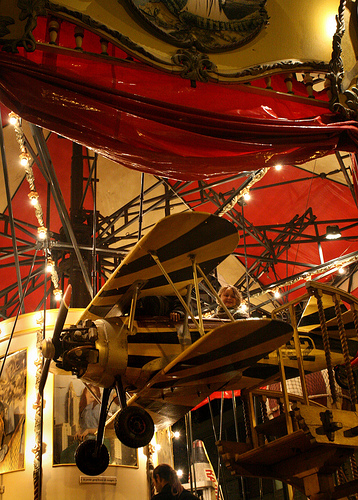

In [ ]:
temp = test_df.sample(33).images.iloc[0]
Image.open(temp).convert("RGB")

In [ ]:
tokenizer.decode(t.generate(feature_extractor(Image.open(temp).convert("RGB"), return_tensors="pt").pixel_values)[0])

'<s><s><s> a woman is sitting in a white i plane that hangs from the roof of an air'